*First compiled: August 17, 2017.*

# Benchmark robustness for simulated data

In [2]:
import itertools
from collections import namedtuple, OrderedDict
import numpy as np
import scanpy.api as sc
import networkx as nx
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
sc.settings.verbosity = 1                         # amount of logging output
sc.settings.set_figure_params(dpi=80)              # control size of inline figures via dots per inch
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+15.gfc4c1f4.dirty on 2017-09-18 23:47.


## Load the data

The following discusses the robustness of the results in [minimal_examples](../sim_data/minimal_examples.ipynb), where you can find more information.

In [3]:
adata_krumsiek11 = sc.examples.krumsiek11()
X_blobs = sc.examples.blobs(n_centers=2, cluster_std=0.5).X
X_concatenated = np.r_[adata_krumsiek11.X, X_blobs]
adata = sc.AnnData(X_concatenated)
adata.var_names = adata_krumsiek11.var_names
adata.add = adata_krumsiek11.add
sc.tl.draw_graph(adata)
sc.write('krumsiek11_blobs', adata)

## The reference graph, our ground truth

Generate a reference graph, which is partitioned into groups using a very high resolution. This generates a very detailed "ground truth", which is hard to reproduce in a robustness study. By contrast, a "ground truth" involving coarse-grained clusters and a trivial graph topology, would be hard to reproduce.

We cannot meaningfully draw the result with a tree layout, as the clusters have non-tree structure; instead, we use the Fruchterman-Reingold layout.

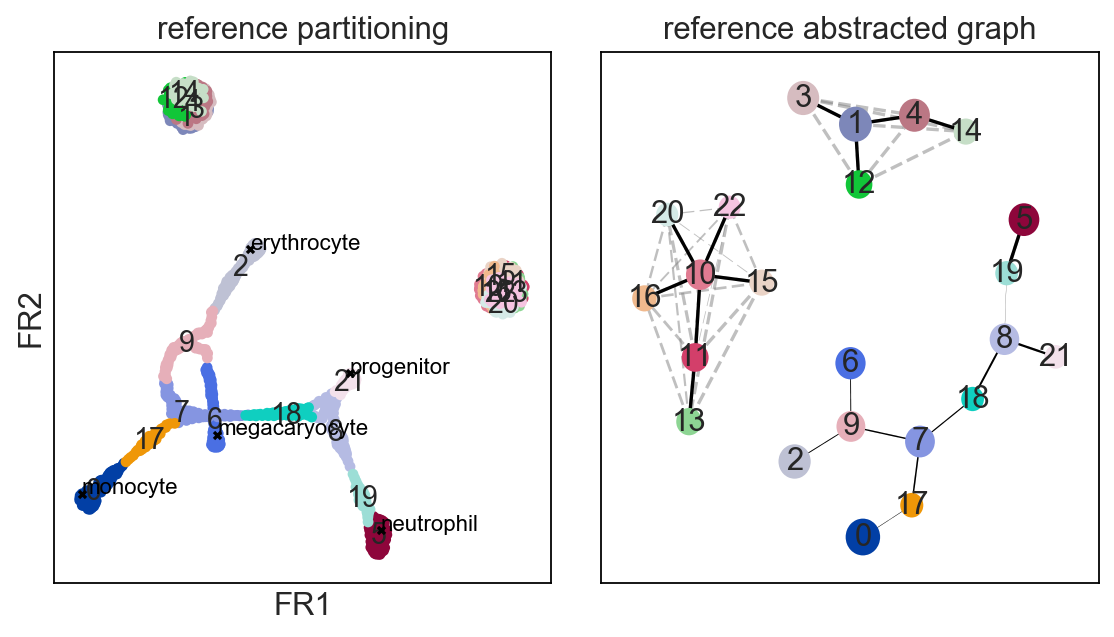

In [6]:
adata = sc.read('krumsiek11_blobs')
sc.tl.aga(adata, n_neighbors=30, resolution=4)
ax = sc.pl.aga(adata, basis='draw_graph_fr',
               title='reference partitioning',
               title_graph='reference abstracted graph',               
               layout='fr', save='_reference', show=True, frameon=True)

## How to assess robustness?

Consider a new run of graph abstraction with highly different parameters.

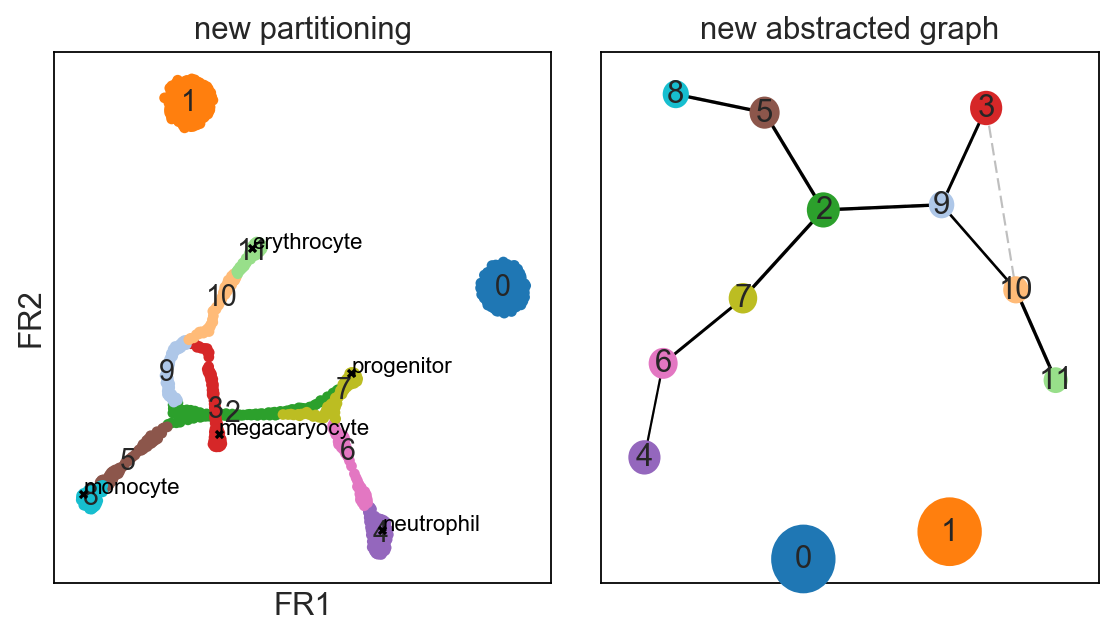

In [8]:
adata_new = sc.tl.aga(adata, n_neighbors=10, resolution=0.8, recompute_graph=True, copy=True)
ax = sc.pl.aga(adata_new, basis='draw_graph_fr', layout='fr',
               title='new partitioning',
               title_graph='new abstracted graph',
               save='_new', show=True, frameon=True)

Inspecting the reference and the new abstracted graph, we would say that both agree: they have the same topology with the exception of the reference group 21. This is merely due to the coarse-grained resolution that we chose.

### 1. Determine to which new labels the reference labels correspond.

We first need to identify the reference groups with the new groups in adata2.

For this, we compute the relative overlap between both clusterings. Relative can either mean a normalization with respect to the new groups computed (rows sum to 1).

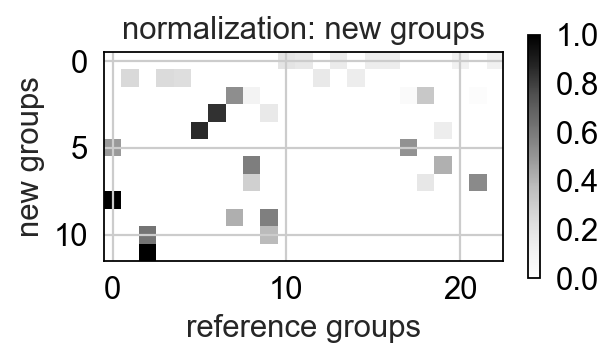

In [5]:
result = sc.utils.compute_association_matrix_of_groups(adata, 'louvain_groups_new', 'louvain_groups')
sc.pl.matrix(result.asso_matrix, xlabel='reference groups', ylabel='new groups', title='normalization: new groups')

Or with respect to the reference groups (columns sum to 1).

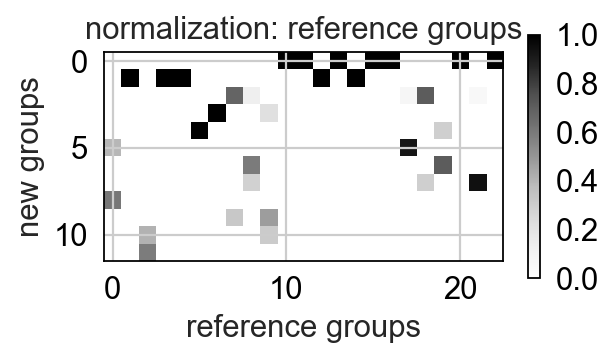

In [6]:
result = sc.utils.compute_association_matrix_of_groups(adata, 'louvain_groups_new', 'louvain_groups', normalization='reference')
sc.pl.matrix(result.asso_matrix, xlabel='reference groups', ylabel='new groups', title='normalization: reference groups')

Now, for each reference group, we consider both normalizations when computing the overlap with each new group (walking along columns in the previous matrices). We then associate a reference group with the new group that maximizes the  minimal overlap between both normalizations.

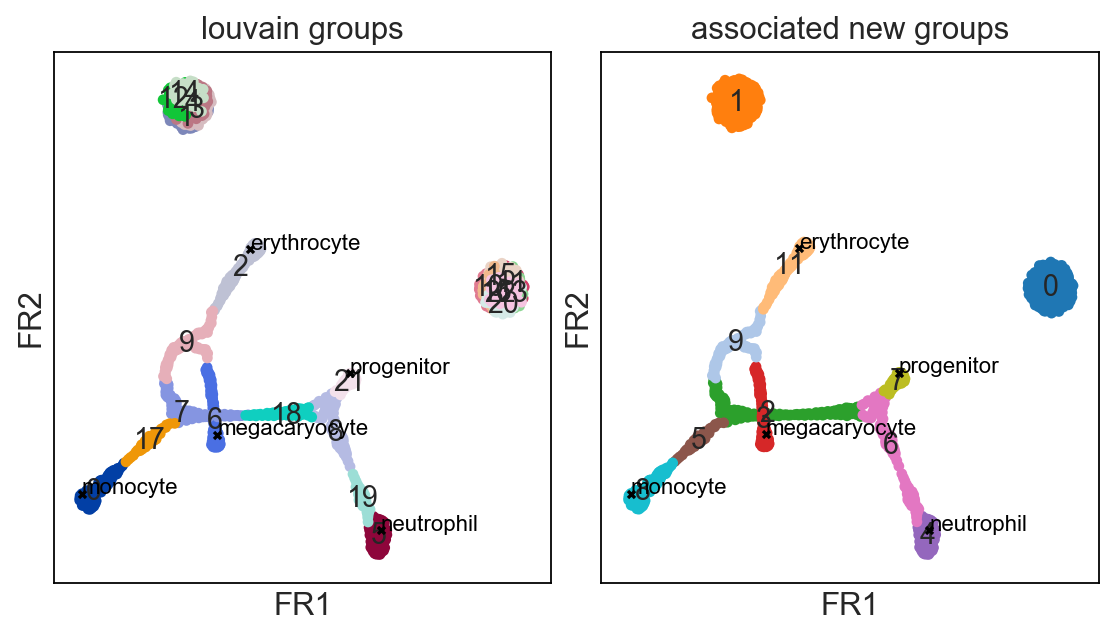

In [11]:
asso_groups_dict = sc.utils.identify_groups(adata.smp['louvain_groups'], adata_new.smp['louvain_groups'])
adata.smp['associated_new_groups'] = [asso_groups_dict[g][0] for g in adata.smp['louvain_groups']]
axs = sc.pl.draw_graph(adata, color=['louvain_groups', 'associated_new_groups'], legend_loc='on data')
ax = sc.pl.draw_graph(adata, color='associated_new_groups', legend_loc='on data',
                      title='associated partitions', save='_associated')

### 2. Compare paths between leaf nodes in both the reference graph and the new graph

Using the previous correspondence - the mapping of reference labels to new labels - we can compare the shortest paths between all leaf nodes in each abstracted graph.

If these agree, paths through groups in the reference and the new abstracted graph correspond to each other: both graphs have the same topology.

We measure deviations by counting how many steps and how many paths agree when averaging over all paths.

In [9]:
sc.settings.verbosity = 5  # increase to 6 for more output
result = sc.utils.compute_fraction_of_agreeing_paths(adata, adata_new)
print(result)

compare shortest paths between leafs (21, 2) in graph1 and (7, 11) in graph2:
      path1 = ['21', '8', '18', '7', '9', '2'],
path_mapped = [['7', '2'], ['6', '7', '2'], ['2', '7'], ['2', '9'], ['9', '10', '3'], ['11', '10']],
      path2 = ['7', '2', '9', '10', '11'],
-> n_agreeing_steps = 4 / n_steps = 4.
compare shortest paths between leafs (21, 6) in graph1 and (7, 3) in graph2:
      path1 = ['21', '8', '18', '7', '9', '6'],
path_mapped = [['7', '2'], ['6', '7', '2'], ['2', '7'], ['2', '9'], ['9', '10', '3'], ['3']],
      path2 = ['7', '2', '9', '3'],
-> n_agreeing_steps = 3 / n_steps = 3.
compare shortest paths between leafs (21, 0) in graph1 and (7, 8) in graph2:
      path1 = ['21', '8', '18', '7', '17', '0'],
path_mapped = [['7', '2'], ['6', '7', '2'], ['2', '7'], ['2', '9'], ['5', '2'], ['8', '5']],
      path2 = ['7', '2', '5', '8'],
-> n_agreeing_steps = 3 / n_steps = 3.
compare shortest paths between leafs (21, 5) in graph1 and (7, 4) in graph2:
      path1 = ['21', '8', 

### Sample a high number of conditions

In [19]:
sc.settings.verbosity = 1
statistics = OrderedDict([('nr. neighbors single-cell graph' , []), ('resolution louvain', []),
                          ('nr. louvain groups', []), ('total nr. steps in paths', []),
                          ('fraction of correct steps', []), ('fraction of correct paths', [])])
np.random.seed(0)
for i in range(100):
    n_neighbors = np.random.randint(5, 50)
    resolution = np.random.rand() * 5
    adata_new = sc.tl.aga(adata, n_neighbors=n_neighbors, resolution=resolution, copy=True, recompute_graph=True)
    # our reference is an example with already a very high number of clusters,
    # only consider cases with equal the number or less clusters
    if len(adata_new.add['aga_groups_order']) <= len(adata.add['aga_groups_order']):
        # uncomment the following for visualization
        # axs = sc.pl.aga(adata2, basis='draw_graph_fr', legend_loc='on data',
        #                 layout_graph='fr', minimal_tree_attachedness=0)
        result = sc.utils.compute_fraction_of_agreeing_paths(adata, adata_new)
        # uncomment for some output
        # print('n_neighbors' , n_neighbors, 'resolution', resolution,
        #       'n_groups', len(adata_new.add['aga_groups_order']), 'frac_steps', result.frac_steps)
        statistics['nr. neighbors single-cell graph' ].append(n_neighbors)
        statistics['resolution louvain'].append(resolution)
        statistics['nr. louvain groups'].append(len(adata_new.add['aga_groups_order']))
        statistics['total nr. steps in paths'].append(result.n_steps)        
        statistics['fraction of correct steps'].append(result.frac_steps)
        statistics['fraction of correct paths'].append(result.frac_paths)

In [20]:
df = pd.DataFrame(statistics)

In [21]:
df

,nr. neighbors single-cell graph,resolution louvain,nr. louvain groups,total nr. steps in paths,fraction of correct steps,fraction of correct paths
0,49,2.964223,11,27,1.000000,1.0
1,24,3.229471,22,46,0.956522,0.8
2,41,1.487673,8,24,1.000000,1.0
3,28,2.399886,13,38,1.000000,1.0
4,18,1.686981,12,38,1.000000,1.0
5,25,0.101092,5,10,1.000000,1.0
6,6,0.716766,15,42,1.000000,1.0
7,37,2.609242,11,28,1.000000,1.0
8,28,1.322778,9,28,1.000000,1.0
9,33,2.842170,15,36,1.000000,1.0


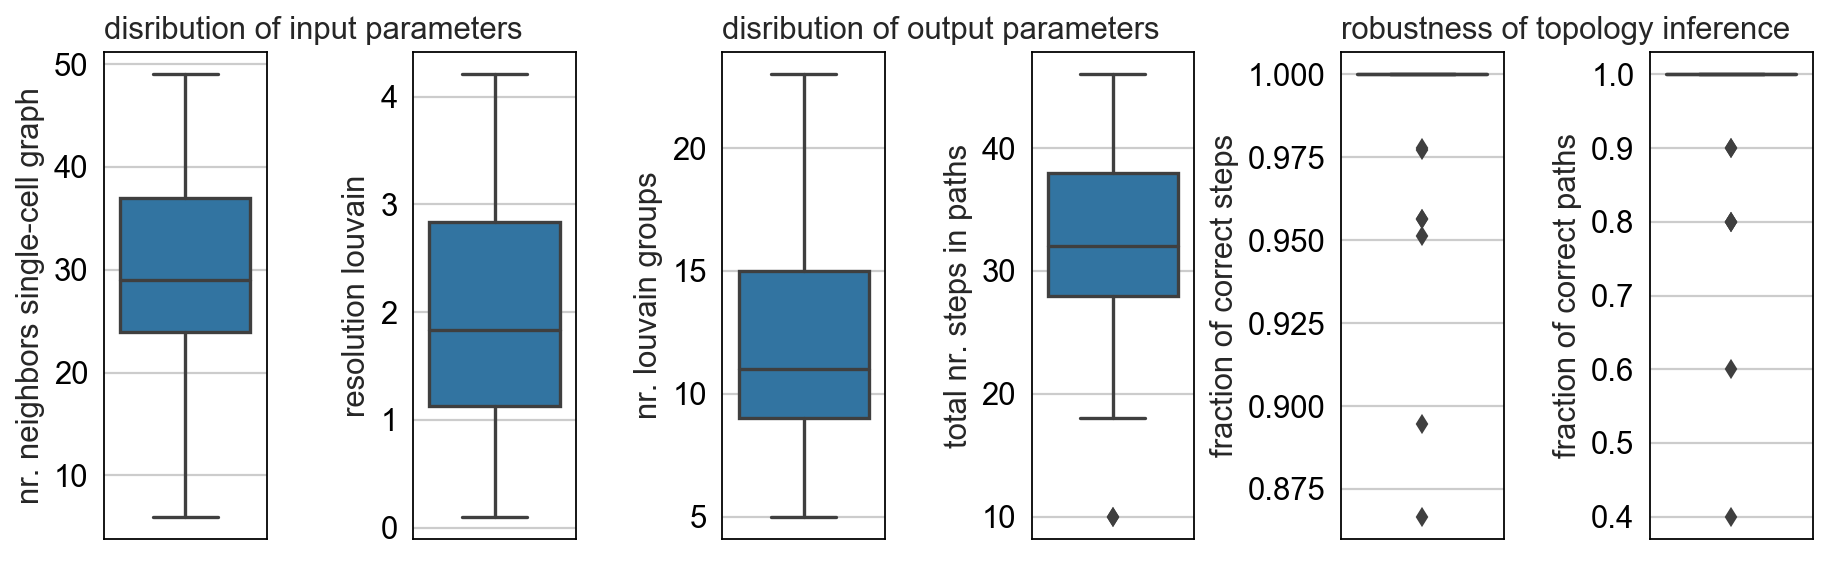

In [22]:
fig, ax = pl.subplots(ncols=df.shape[1], figsize=(12, 4), gridspec_kw={'left': 0.07, 'wspace': 0.9})
for i, col in enumerate(df.columns):
    sns.boxplot(df[col], ax=ax[i], orient='vertical')
ax[0].set_title('disribution of input parameters', loc='left')
ax[2].set_title('disribution of output parameters', loc='left')
ax[4].set_title('robustness of topology inference', loc='left')
pl.savefig('./figures/robustness_summary.png', dpi=300)
pl.show()